# Fitting a line plus scatter
Here I test out [LMC](https://github.com/abmantz/lmc) on a simple problem: fitting a linear model with Gaussian intrinsic scatter to data.

Jake VanderPlas has an excellent example featuring several other Python MCMC packages [here](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/), and for ease of comparison I have set up an identical data set to analyze below.

## Import things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
import corner
%matplotlib inline

## Set up the data set and plot them

In [2]:
np.random.seed(42)
true_alpha = 25.0
true_beta = 0.5
true_sigma = 10.0

xs = 100.0 * np.random.random(20)
ys = true_alpha + true_beta * xs

# It's a bit weird to add scatter in x like this and then not
# account for it in the model, but for consistency...
# Anyway, with such a shallow slope, it doesn't throw off the fit
# too much.
xs = np.random.normal(xs, 10.0)
ys = np.random.normal(ys, true_sigma)

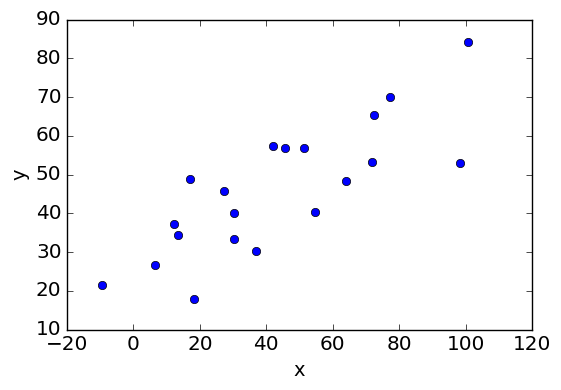

In [3]:
plt.plot(xs, ys, 'o');
plt.xlabel('x', fontsize=14);
plt.ylabel('y', fontsize=14);

## Define the model

In [4]:
# Following JV, define separate functions for the prior, likelihood
# and posterior.

# I'll be lazy and define the parameter objects at global scope.
# (The actual declarations of alpha, beta and sigma will come later.)
# In a complex fitting code, this would be very bad practice, but
# for simple scripts like this it should be fine.
# Similarly, I will just use the global `xs` and `ys` data.
# Consequently, these functions do not need arguments!

def lnPrior():
    if sigma() <= 0.0:
        return -np.inf
    # NB "uniform in angle" slope prior as in the example we're following
    # Jeffreys prior for the scatter
    return -1.5*np.log(1 + beta()** 2) - np.log(sigma())

def lnLikelihood():
    ymod = alpha() + beta()*xs
    return np.sum( -0.5*((ys - ymod) / sigma())**2  - np.log(sigma()) )

# A quirk of LMC is that the log_posterior function must have 1 argument
# but, given the choices above, we won't actually use it.
def lnPosterior(junk=None):
    return lnPrior() + lnLikelihood()

## Set up the inference

In [5]:
import lmc

In [6]:
# Here we define Parameter objects for each free parameter, and bundle them
# into a ParameterSpace that knows about the posterior function.
# Each Parameter is given a starting value and a guess at the appropriate step size.
alpha = lmc.Parameter(25.0, 1.0, 'alpha')
beta = lmc.Parameter(0.5, 0.05, 'beta')
sigma = lmc.Parameter(10.0, 1.0, 'sigma')
space = lmc.ParameterSpace([alpha, beta, sigma], lnPosterior)

In [7]:
# Run a few chains and save them in separate dictionaries.
# There will be vector named by each Parameter.name, as well as one for the corresponding
# log-posterior values.

# We're using all the default setting here, which means that each chain will adapt its
# proposal distribution, but we're not taking advantage of LMC's parallel features. That would
# certainly make things a bit faster. Running the chains in parallel instead of serially provides
# an obvious speedup, but in addition each one would converge to the posterior more quickly.

Nchains = 4
Nsteps = 26000 # to get 1e5 total samples after removing 1e3 burn-in
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(space, ch)
    %time v(1,Nsteps)

CPU times: user 4.71 s, sys: 29.8 ms, total: 4.74 s
Wall time: 4.73 s
CPU times: user 4.71 s, sys: 48.4 ms, total: 4.75 s
Wall time: 4.73 s
CPU times: user 4.65 s, sys: 45.7 ms, total: 4.69 s
Wall time: 4.67 s
CPU times: user 4.61 s, sys: 44.5 ms, total: 4.66 s
Wall time: 4.63 s


### Traces:

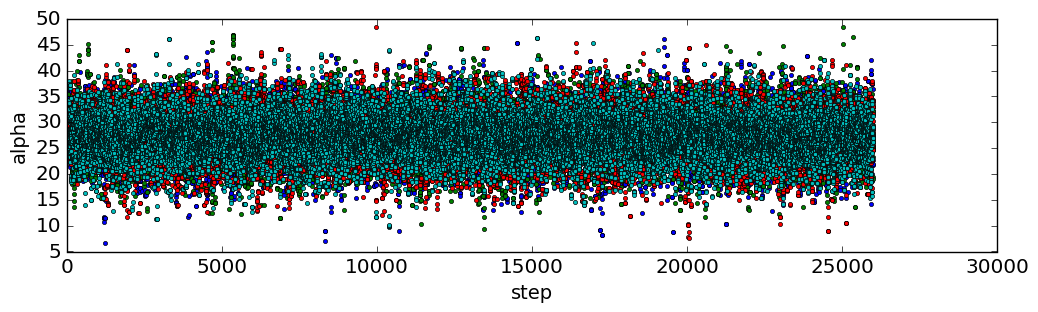

In [8]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for ch in chains:
    plt.plot(ch['alpha'], 'o', ms=3.0);
plt.xlabel('step', fontsize=14);
plt.ylabel('alpha', fontsize=14);

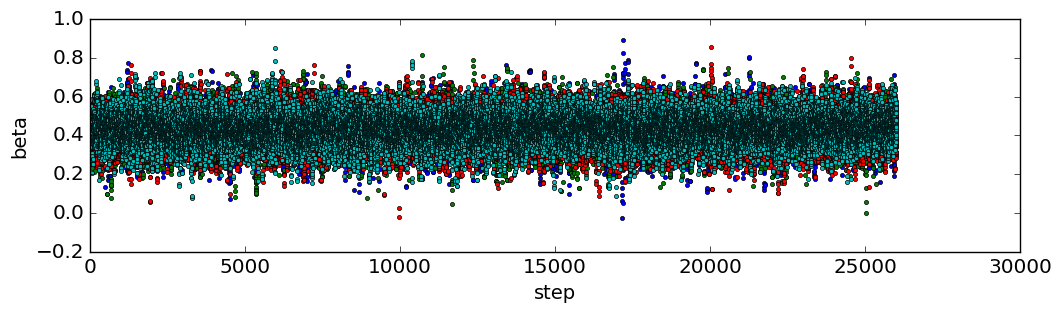

In [9]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for ch in chains:
    plt.plot(ch['beta'], 'o', ms=3.0);
plt.xlabel('step', fontsize=14);
plt.ylabel('beta', fontsize=14);

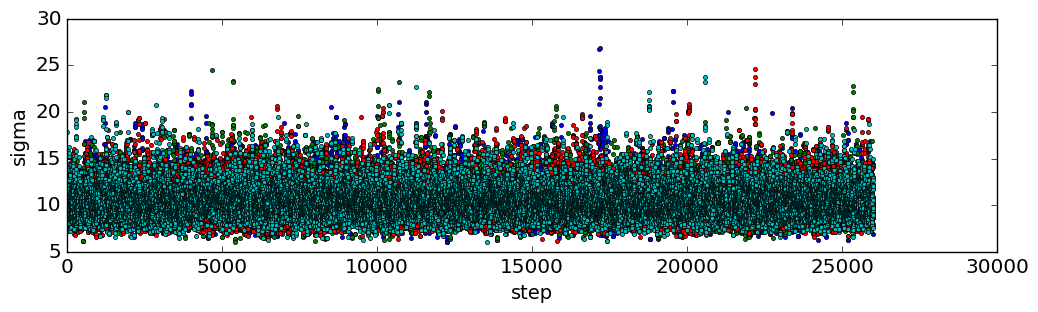

In [10]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for ch in chains:
    plt.plot(ch['sigma'], 'o', ms=3.0);
plt.xlabel('step', fontsize=14);
plt.ylabel('sigma', fontsize=14);

Let's zoom in on the beginning a bit

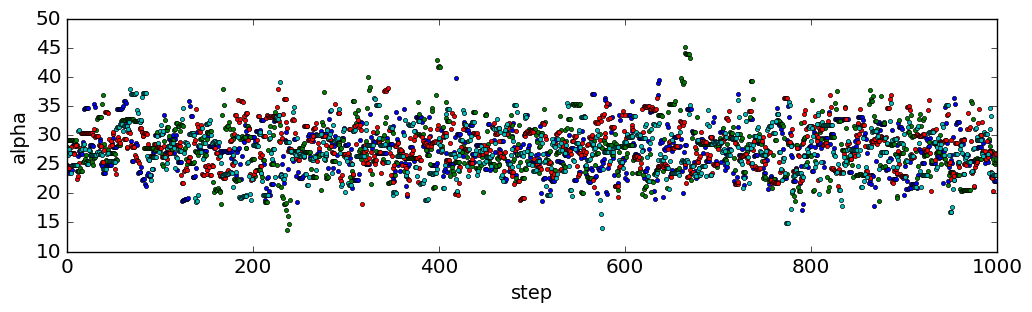

In [11]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for ch in chains:
    plt.plot(np.array(ch['alpha'])[range(1000)], 'o', ms=3.0);
plt.xlabel('step', fontsize=14);
plt.ylabel('alpha', fontsize=14);

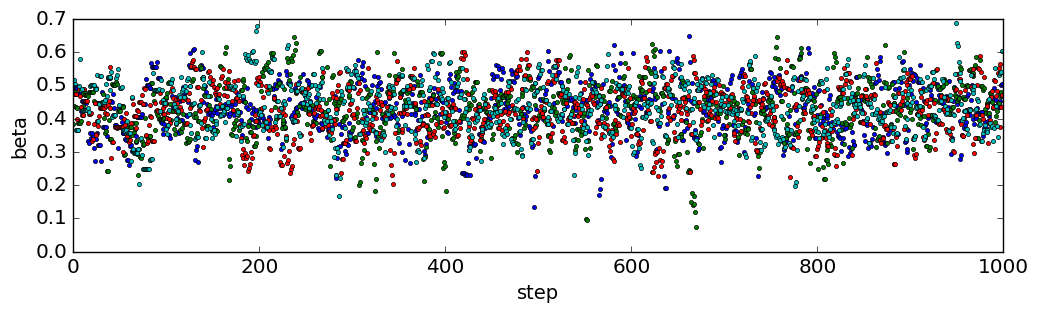

In [12]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for ch in chains:
    plt.plot(np.array(ch['beta'])[range(1000)], 'o', ms=3.0);
plt.xlabel('step', fontsize=14);
plt.ylabel('beta', fontsize=14);

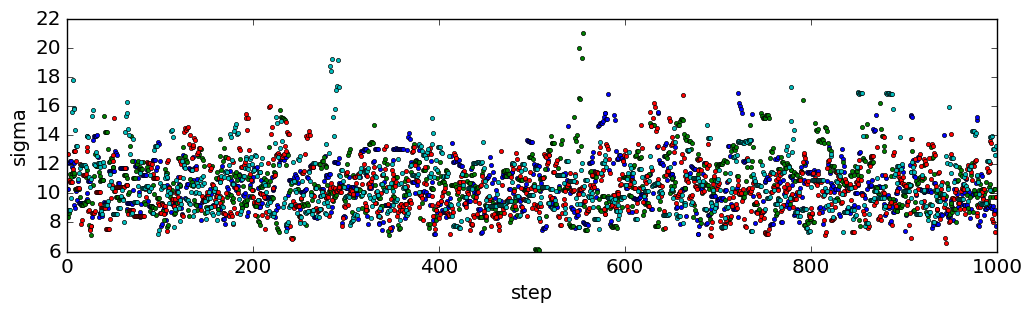

In [13]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for ch in chains:
    plt.plot(np.array(ch['sigma'])[range(1000)], 'o', ms=3.0);
plt.xlabel('step', fontsize=14);
plt.ylabel('sigma', fontsize=14);

## Remove burn-in, make nifty histograms, etc.

In [14]:
burn = 1000
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn+1, len(ch[k]))] for ch in chains]) 
     for k in [p.name for p in space]]).T
post.shape

(100000, 3)

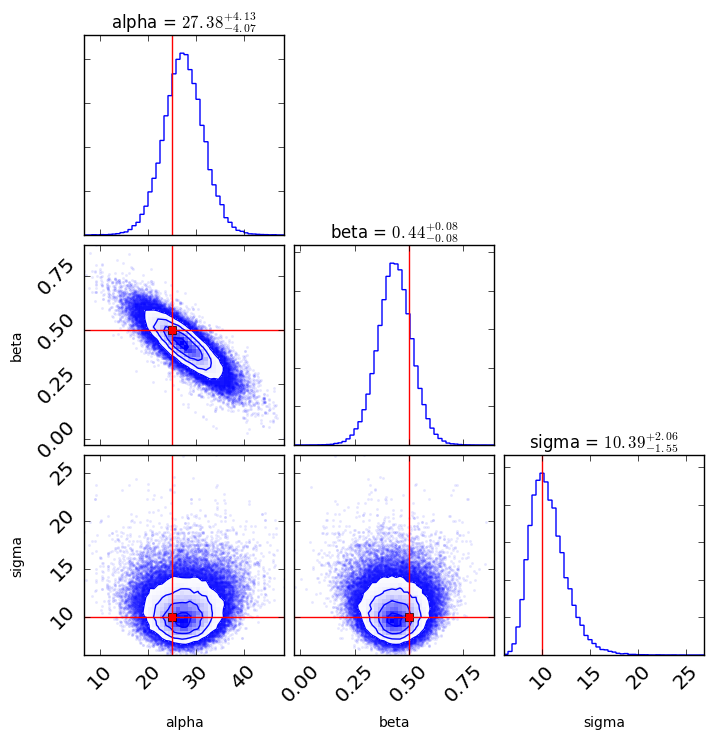

In [15]:
corner.corner(post[:,range(3)], labels=[p.name for p in space], bins=50, color='b',
              truths=[true_alpha, true_beta, true_sigma], truth_color='r',show_titles=True);